In [1]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_diabetes = pd.read_csv("../../data/diabetes_datasets/diabetes.csv")

print("\n-----------Diabetes Dataset---------- \n")
print(df_diabetes.head())


-----------Diabetes Dataset---------- 

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [3]:
#one hot encoding diabetes
df_encoded_diabetes = pd.get_dummies(df_diabetes, columns = ['gender', 'smoking_history'])
df_encoded_diabetes['id'] = range(1, len(df_encoded_diabetes)+1)

#convert the boolean features in integer (0,1)
boolean_columns_new = df_encoded_diabetes.select_dtypes(include=bool).columns
for column in boolean_columns_new:
    df_encoded_diabetes[column] = df_encoded_diabetes[column].astype(int)

df_encoded_diabetes = df_encoded_diabetes.dropna(how = 'all',axis=1)

print(df_encoded_diabetes.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  gender_Other  \
0         0              1            0             0   
1         0              1            0             0   
2         0              0            1             0   
3         0              1            0             0   
4         0              0            1             0   

   smoking_history_No Info  smoking_history_current  smoking_history_ever  \
0                        0                        0                     0   
1               

In [4]:
# Separate the features (X) and the labels (y)
X = df_encoded_diabetes.drop(['diabetes','id'], axis=1)
y = df_encoded_diabetes['diabetes'] 

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=43)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Create a new DataFrame with the balanced data
data_adasyn = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_adasyn['bmi'] = data_adasyn['bmi'].round(2)
data_adasyn['age'] = data_adasyn['age'].astype(int)

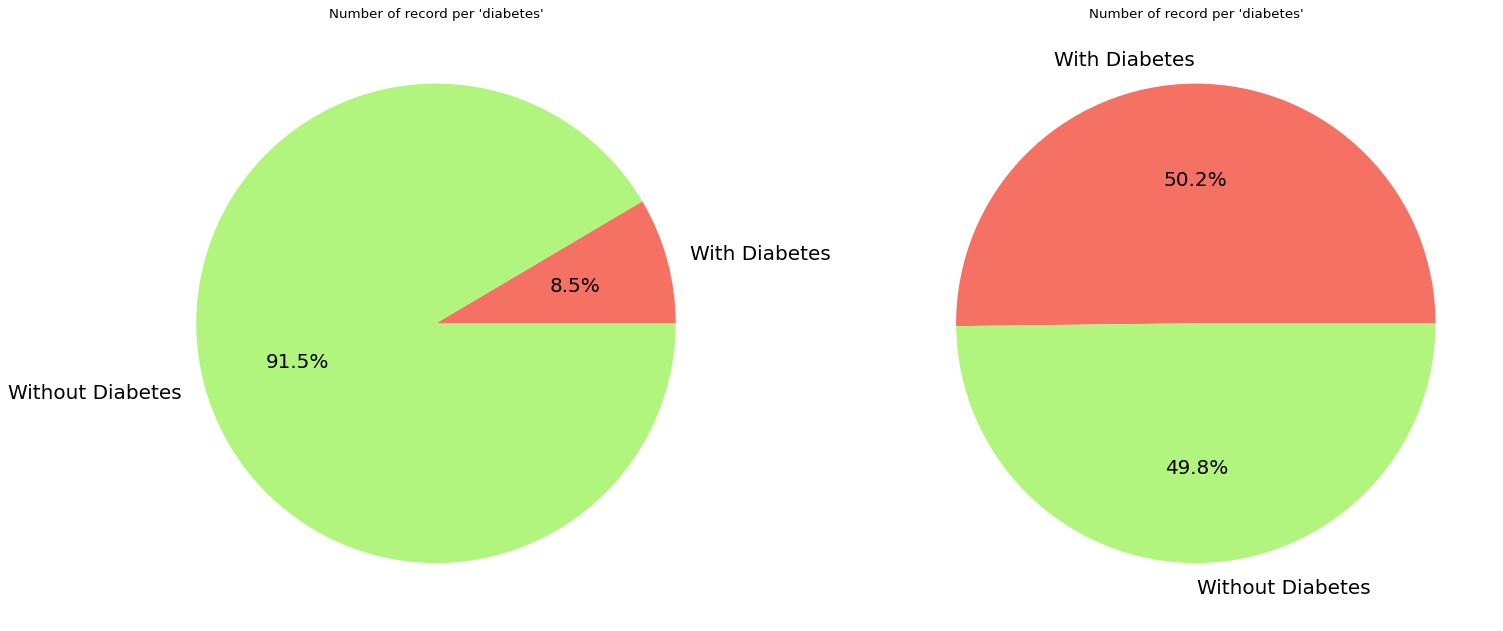

In [5]:
data_standard = df_encoded_diabetes
def plot_diabetes_pie_chart(dataframe):
    #Pie Plot
    disease_0 = dataframe.loc[dataframe["diabetes"] == 0, :].shape[0]
    disease_1 = dataframe.loc[dataframe["diabetes"] == 1, :].shape[0]

    labels = ["With Diabetes", "Without Diabetes"]
    sizes = [disease_1, disease_0]
    colors = ["#F57163", "#B2F57E"]
    plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", textprops={'fontsize': 18})
    plt.title("Number of record per 'diabetes'")
    plt.plot()
    
plt.figure(figsize=(20, 8), dpi=80)  # Adjust width, height, and dpi as needed
plt.subplot(1, 2, 1)
plot_diabetes_pie_chart(data_standard)
plt.subplot(1, 2, 2)
plot_diabetes_pie_chart(data_adasyn)
plt.tight_layout()
plt.show()

In [6]:
X_standard = data_standard.drop(['diabetes','id'], axis=1)
y_standard = data_standard['diabetes']

start = 42
maxIter = 30
step = 100
results_random_forest = []
results_k = []
results_log_reg = []
i = 0
while i < maxIter:
    seed = np.random.seed(42 + step)
    # Apply ADASYN to oversample the minority class
    adasyn = ADASYN(random_state=seed)
    X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=seed)
   
    X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)

    # Fit models on X_train and y_train without oversampling
    model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
    model_k = KNeighborsClassifier().fit(X_train_sta, y_train_sta)
    model_log_reg = LogisticRegression().fit(X_train_sta, y_train_sta)

    # Prediction on oversampled X_test_sta (X_test_ada)
    pred_random_forest = model_random_forest.predict(X_test_ada)
    pred_k = model_k.predict(X_test_ada)
    pred_log_reg = model_log_reg.predict(X_test_ada)

    # Accuracy for the models
    accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)
    accuracy_k = accuracy_score(y_test_ada, pred_k)
    accuracy_log_reg = accuracy_score(y_test_ada, pred_log_reg)

    # Append the result of each iteration for the accuracy of the models in a list 
    results_random_forest.append(accuracy_random_forest)
    results_k.append(accuracy_k)
    results_log_reg.append(accuracy_log_reg)
    #print("iteration number: " + str(i) + " With seed number: " + str(42+step))
    i = i + 1
    step = step + 100
# Compute the variance for the models
variance_random_forest = np.var(results_random_forest)
variance_k = np.var(results_k)
variance_log_reg = np.var(results_log_reg)

print("Random Forest Variance: ", variance_random_forest)
print("K Neighbour Variance: ", variance_k)
print("Logistic Regression Variance: ", variance_log_reg)

Random Forest Variance:  3.171658101940038e-05
K Neighbour Variance:  2.2122926925329077e-05
Logistic Regression Variance:  3.65645628646023e-05


In [7]:
# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=start)
X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=start)

X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)

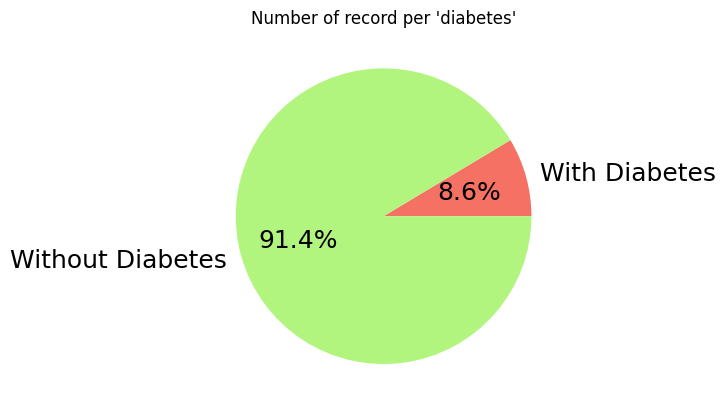

In [8]:
#Check frequency diabetes
y_test_sta_df = pd.DataFrame({'diabetes': y_test_sta})
plot_diabetes_pie_chart(y_test_sta_df)
plt.show()

In [9]:
#------------ KNeighborsClassifier ------------
model_k =  KNeighborsClassifier().fit(X_train_sta, y_train_sta)
pred_k = model_k.predict(X_test_ada)

#------------ RandomForestClassifier ------------
model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
pred_random_forest = model_random_forest.predict(X_test_ada)

#------------ LogisticRegression ------------
model_logistic =  LogisticRegression().fit(X_train_sta, y_train_sta)
pred_logistic = model_logistic.predict(X_test_ada)


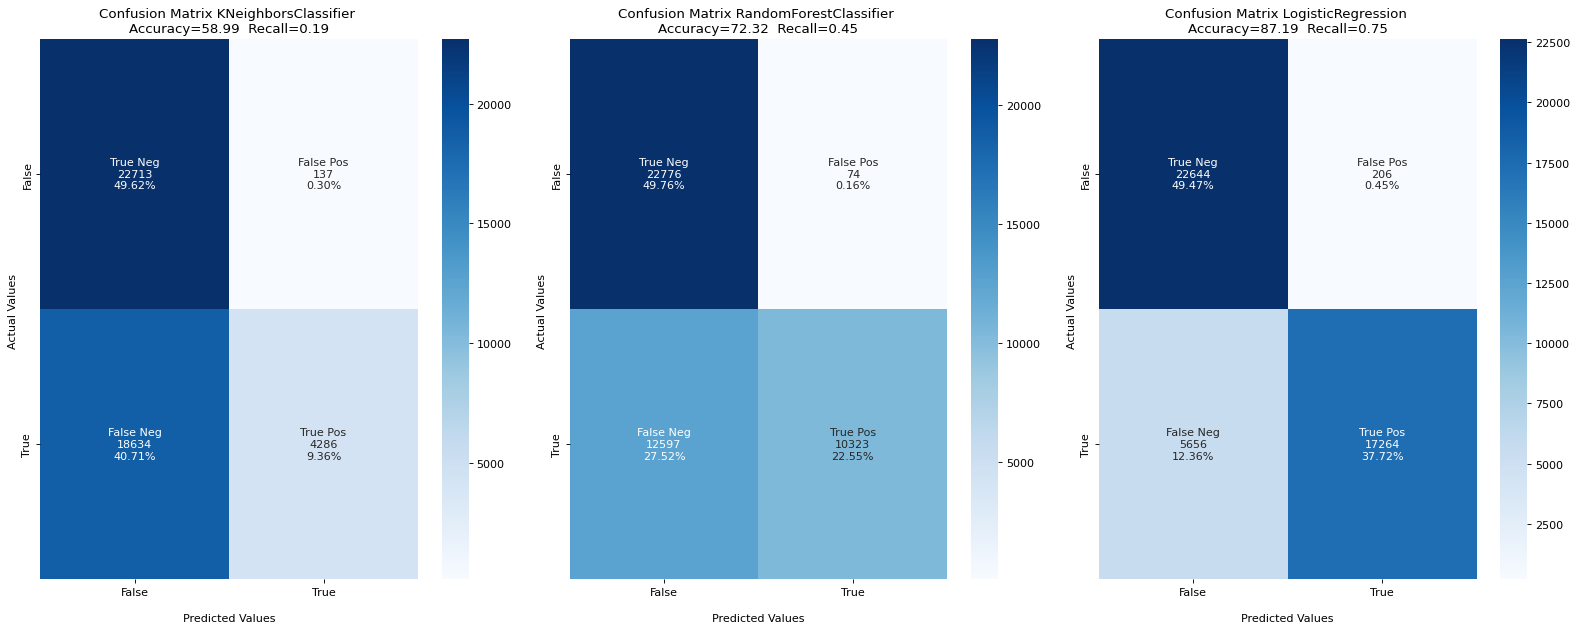

In [10]:
# Calculate the confusion matrix for the model KNeighborsClassifier
confusion_matrix_k = confusion_matrix(y_test_ada, pred_k)
accuracy_k = accuracy_score(y_test_ada, pred_k)*100
recall_k = recall_score(y_test_ada, pred_k)

# Calculate the confusion matrix for the model RandomForestClassifier
confusion_matrix_random_forest = confusion_matrix(y_test_ada, pred_random_forest)
accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)*100
recall_random_forest = recall_score(y_test_ada, pred_random_forest)

# Calculate the confusion matrix for the model LogisticRegression
confusion_matrix_logistic = confusion_matrix(y_test_ada, pred_logistic)
accuracy_logistic = accuracy_score(y_test_ada, pred_logistic)*100
recall_logistic = recall_score(y_test_ada, pred_logistic)

def plot_matrix_model(model,accuracy,recall,confusion_matrix):
    #plot matrix
    #plt.ion()
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        confusion_matrix.flatten()/np.sum(confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title("Confusion Matrix {:s} \nAccuracy={:.2f}  Recall={:.2f}".format(model,accuracy, recall));
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.plot()
    
plt.figure(figsize=(20, 8), dpi=80)  # Adjust width, height, and dpi as needed
plt.subplot(1, 3, 1)
plot_matrix_model("KNeighborsClassifier",accuracy_k,recall_k,confusion_matrix_k)
plt.subplot(1, 3, 2)
plot_matrix_model("RandomForestClassifier",accuracy_random_forest,recall_random_forest,confusion_matrix_random_forest)
plt.subplot(1, 3, 3)
plot_matrix_model("LogisticRegression",accuracy_logistic,recall_logistic,confusion_matrix_logistic)
plt.tight_layout()
plt.show()


In [11]:
#Compute the explainer for shap for the models
explainer_random_forest = shap.Explainer(model_random_forest.predict,X_test_ada)
explainer_k = shap.Explainer(model_k.predict,X_test_ada)
explainer_linear = shap.Explainer(model_logistic.predict,X_test_ada)

#Compute the shap values for the models
shap_values_random_forest = explainer_random_forest(X_standard[0:100])
shap_values_k = explainer_k(X_standard[0:100])
shap_values_linear = explainer_linear(X_standard[0:100])

PermutationExplainer explainer: 101it [00:22,  2.67it/s]                         
PermutationExplainer explainer: 101it [01:02,  1.34it/s]                         


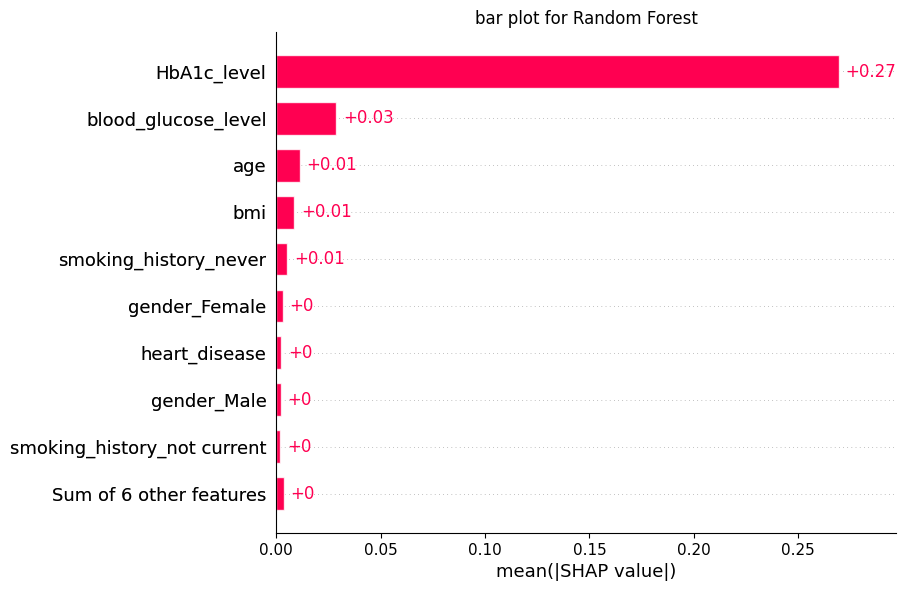

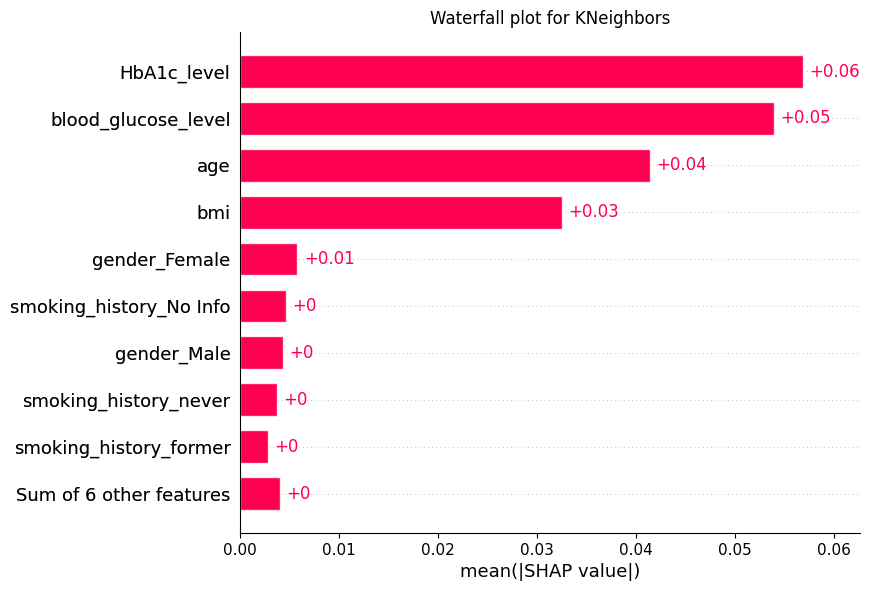

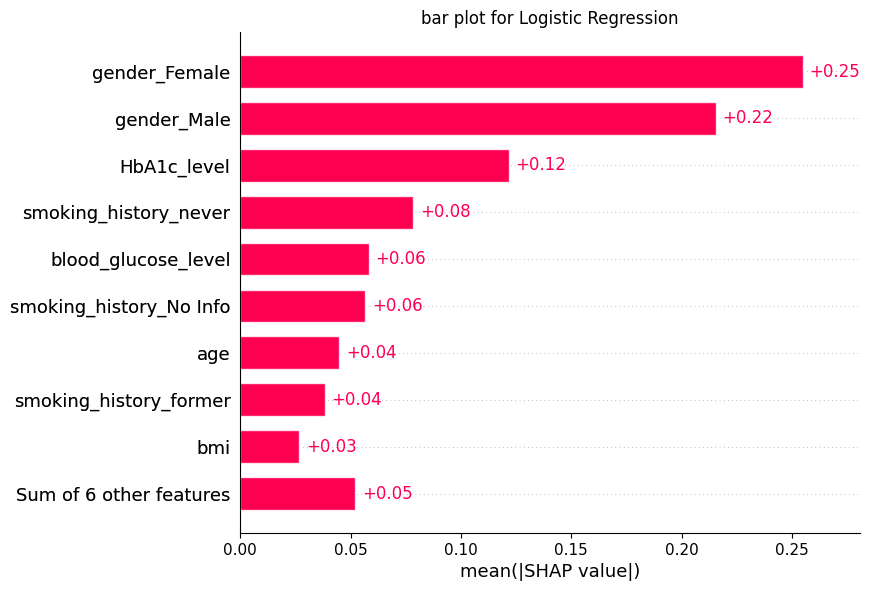

In [13]:
#bar plot for models
shap.plots.bar(shap_values_random_forest, show=False)
plt.title("bar plot for Random Forest")
plt.show()

shap.plots.bar(shap_values_k, show=False)
plt.title("Waterfall plot for KNeighbors")
plt.show()

shap.plots.bar(shap_values_linear, show=False)
plt.title("bar plot for Logistic Regression")
plt.show()

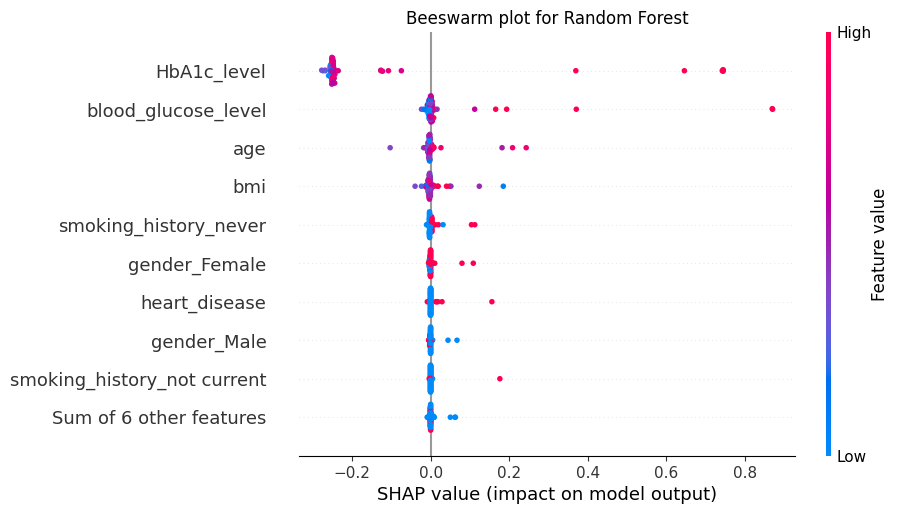

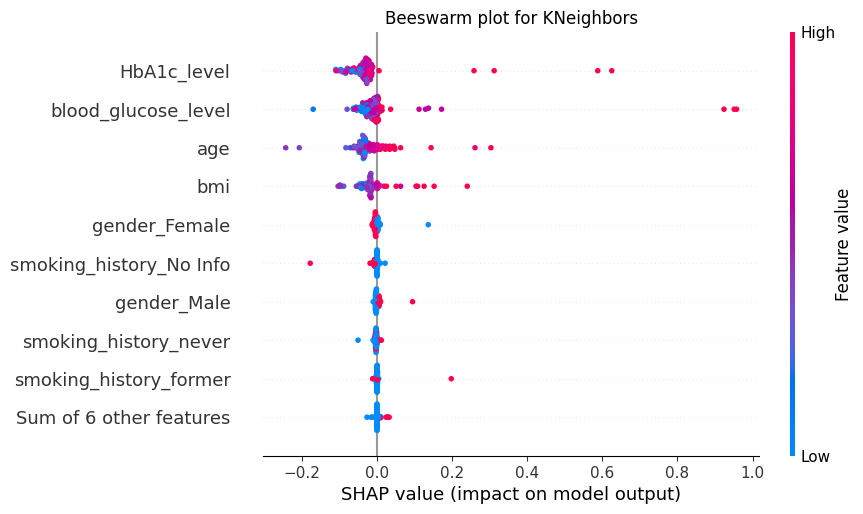

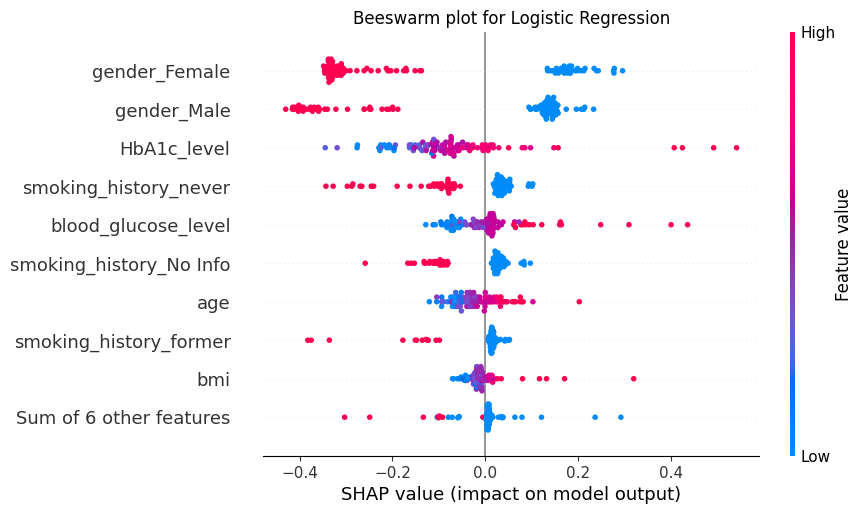

In [14]:
#beeswarm plot for models
shap.plots.beeswarm(shap_values_random_forest, show=False)
plt.title("Beeswarm plot for Random Forest")
plt.show()

shap.plots.beeswarm(shap_values_k, show=False)
plt.title("Beeswarm plot for KNeighbors")
plt.show()

shap.plots.beeswarm(shap_values_linear, show=False)
plt.title("Beeswarm plot for Logistic Regression")
plt.show()